# Tutorial 5 : U-GNP [WIP]

Last Update : 22 June 2019

**Aim**: 


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from ntbks_helpers import get_gp_datasets # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less
datasets = get_gp_datasets(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model


In [7]:
from neuralproc import GlobalNeuralProcess, discard_ith_arg
from neuralproc.utils.helpers import change_param
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

gnp_kwargs = dict(r_dim=8, 
                  get_cntxt_trgt=get_cntxt_trgt,
                  TmpSelfAttn=change_param(UnetCNN,
                                          Conv=torch.nn.Conv1d,
                                           Pool=torch.nn.MaxPool1d,
                                           upsample_mode="linear",
                                          n_layers=14,
                                           bottleneck=None,
                                          is_depth_separable=True,
                                          Normalization=torch.nn.BatchNorm1d,
                                          is_chan_last=True,
                                           is_double_conv=True,
                                          kernel_size=11),
                 #XEncoder=torch.nn.Linear,
                 #XYEncoder=discard_ith_arg(MLP, i=0),
                 #is_use_x=True,
                 #x_transf_dim=None,
                  #keys_to_tmp_attn="weighted_dist",
                 #tmp_to_queries_attn="weighted_dist"
                 )

"""
gnp_kwargs = dict(r_dim=32, 
                  get_cntxt_trgt=get_cntxt_trgt,
                  TmpSelfAttn=SelfAttention)
"""

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=8 and input=1. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=2 and input=8. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [17]:
from utils.helpers import count_parameters

In [18]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 30040


Using `"transformer"` attention increases the number of parameters, but using a deterministic path as well a smaller representation seize decreases the number of parameters.

## Training

In [ ]:
from ntbks_helpers import train_all_models_

train_all_models_(data_models, "results/notebooks/neural_process/u_gnp_layer14",
                  is_retrain=True) # if false load precomputed


--- Training rbf ---



  epoch    train_loss    cp       dur
-------  ------------  ----  --------
      1        0.5469     +  170.5890


      2       -0.0481     +  139.9778


      3       -0.3003     +  131.6245


      4       -0.4278     +  150.9312


      5       -0.5140     +  140.1882


      6       -0.3717        170.1422


      7       -0.5593     +  170.6739


      8       -0.5411        169.5853


      9       -0.5927     +  169.7027


     10       -0.6199     +  171.0536


     11       -0.6149        154.9361


     12       -0.6485     +  80.4603


     13       -0.6194        118.9742


     14       -0.6439        101.3169


     15       -0.6502     +  118.6449


     16       -0.6094        118.4486


     17       -0.7011     +  118.8381


     18       -0.6255        117.9734


     19       -0.6827        117.0541


     20       -0.6861        118.5562


     21       -0.6633        134.2291


     22       -0.6747        175.8948


     23       -0.6957        176.6383


     24       -0.7010        176.3856


     25       -0.6765        176.4258


     26       -0.6946        176.0971


     27       -0.7527     +  176.2453


     28       -0.7300        176.6281


The model converges extremely quickly ($\sim 15$ epochs)  but already has very good predictions after $\sim 5$ epochs.

# Inference


In [19]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 0.6080968870222568
std: 0.2161427786946297
std: 0.2568176108598708
std: 0.8592280225455764


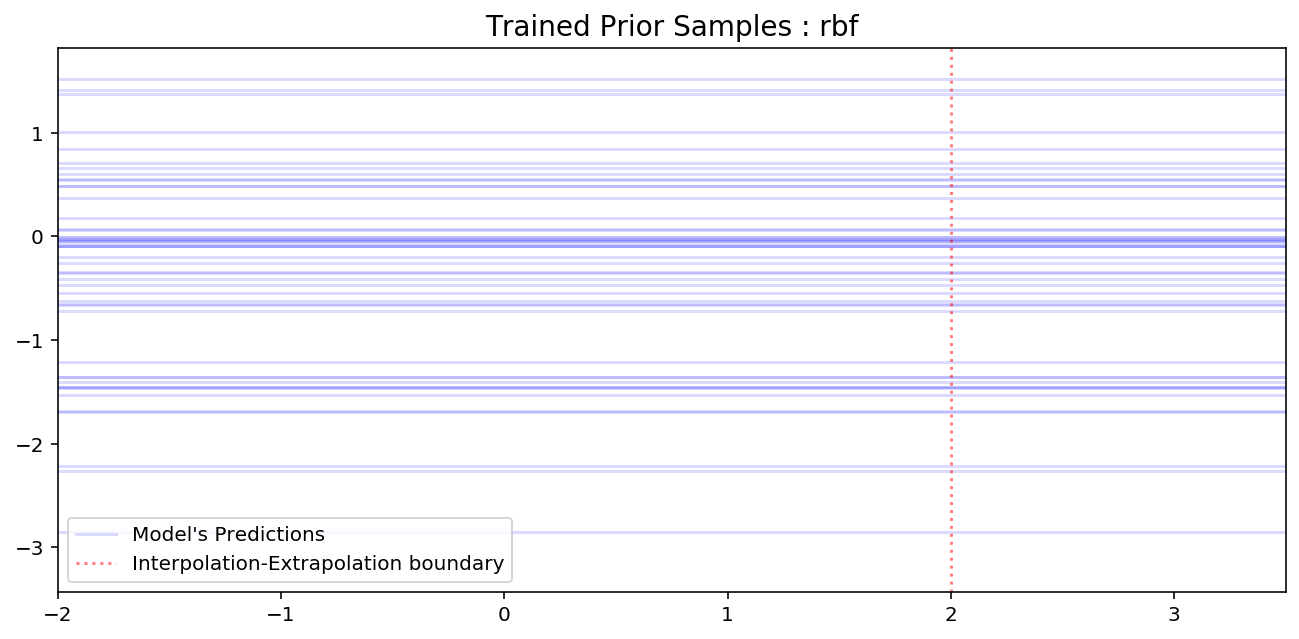

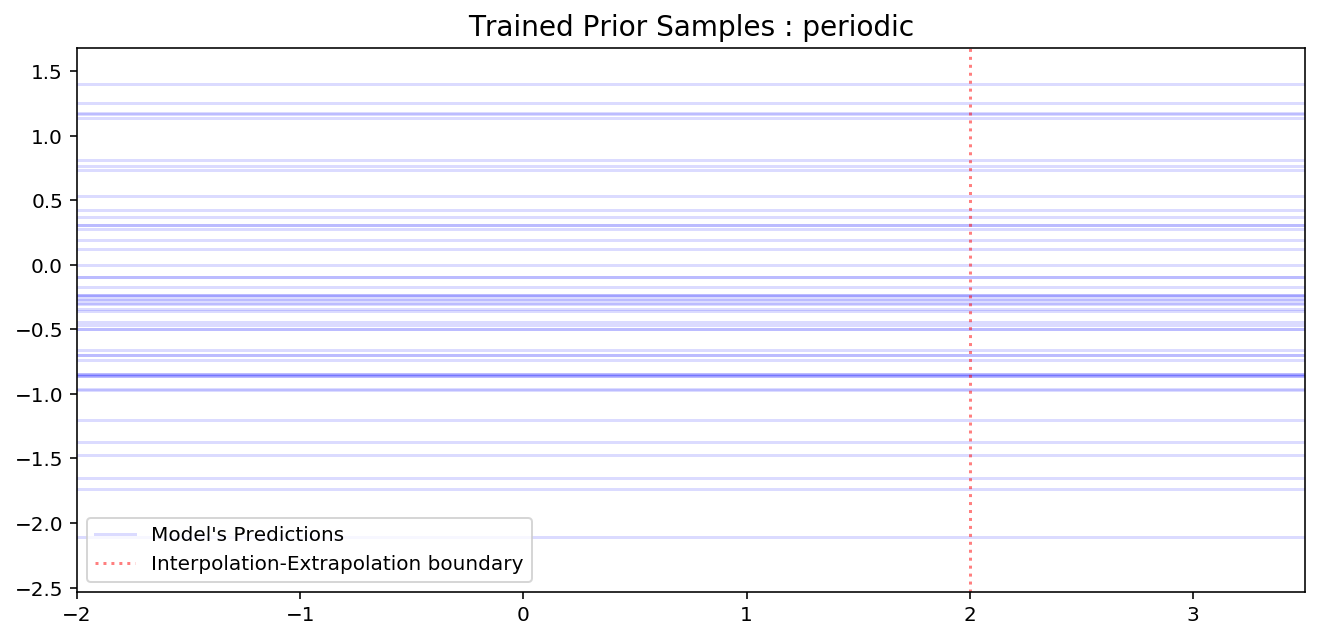

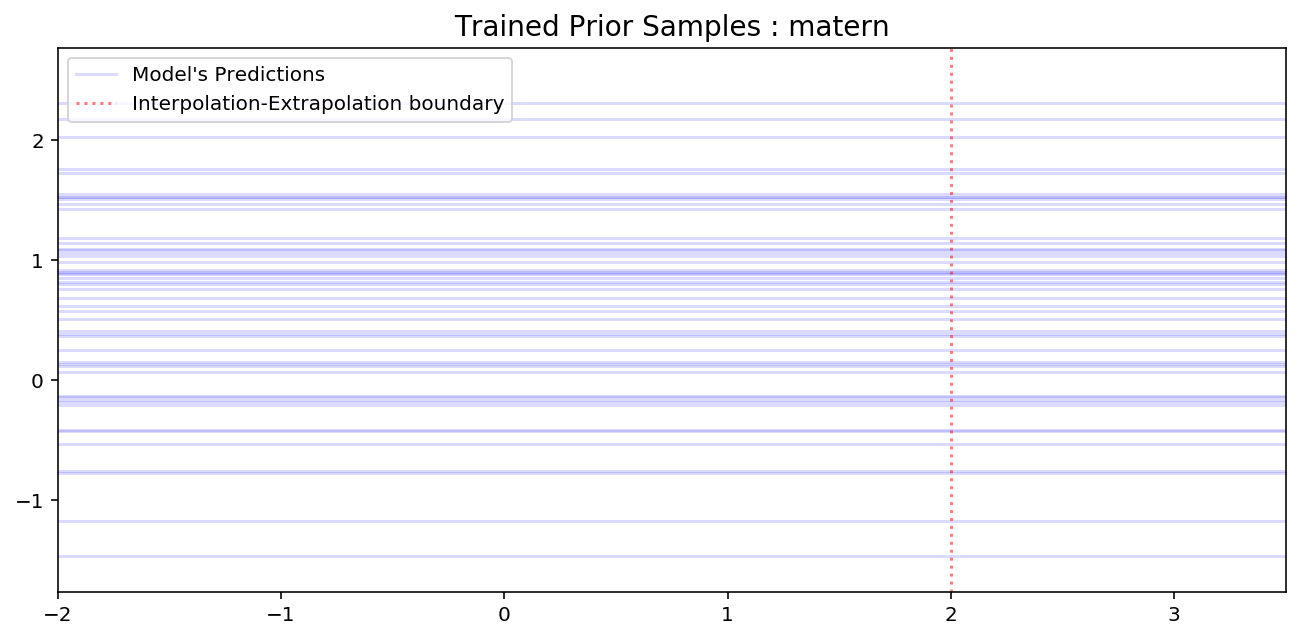

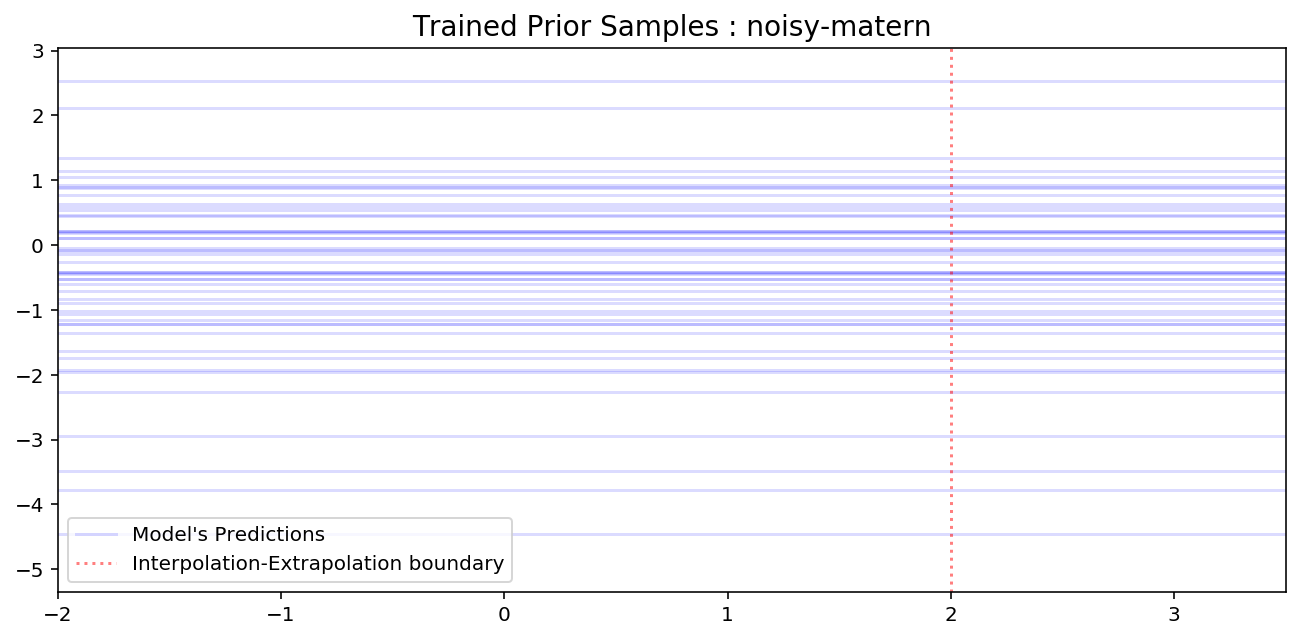

In [20]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

In [21]:
for k,(neural_proc, dataset) in data_models.items():
    break

In [22]:
torch.nn.functional.softplus(neural_proc.keys_to_tmp_attender.radial_basis_func.length_scale)

tensor([0.0039], grad_fn=<SoftplusBackward>)

In [ ]:
from neuralproc.utils.helpers import rescale_range

for k,(neural_proc, dataset) in data_models.items():
    extrap_rescaled_range = tuple(rescale_range(np.array(EXTRAPOLATION_RANGE), (-2,2), (-1,1)))
    neural_proc.extend_tmp_queries(extrap_rescaled_range)

std: 0.4108928143978119
std: 0.9290967583656311
std: 0.5557441711425781
std: 0.6376606822013855


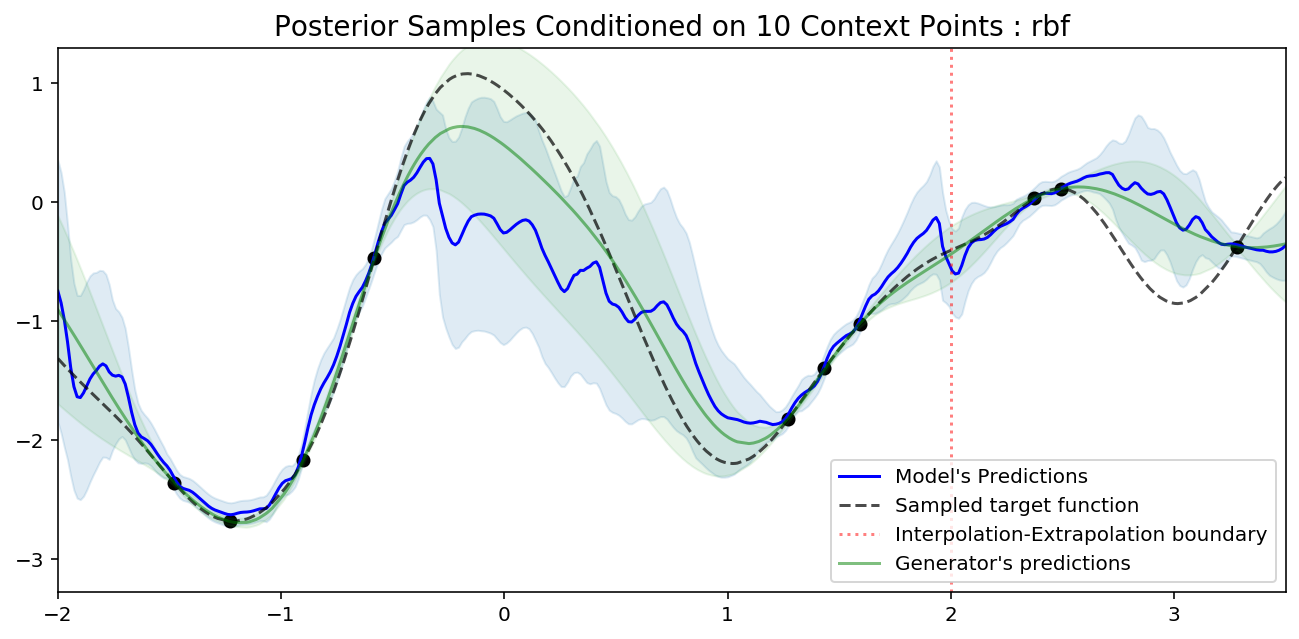

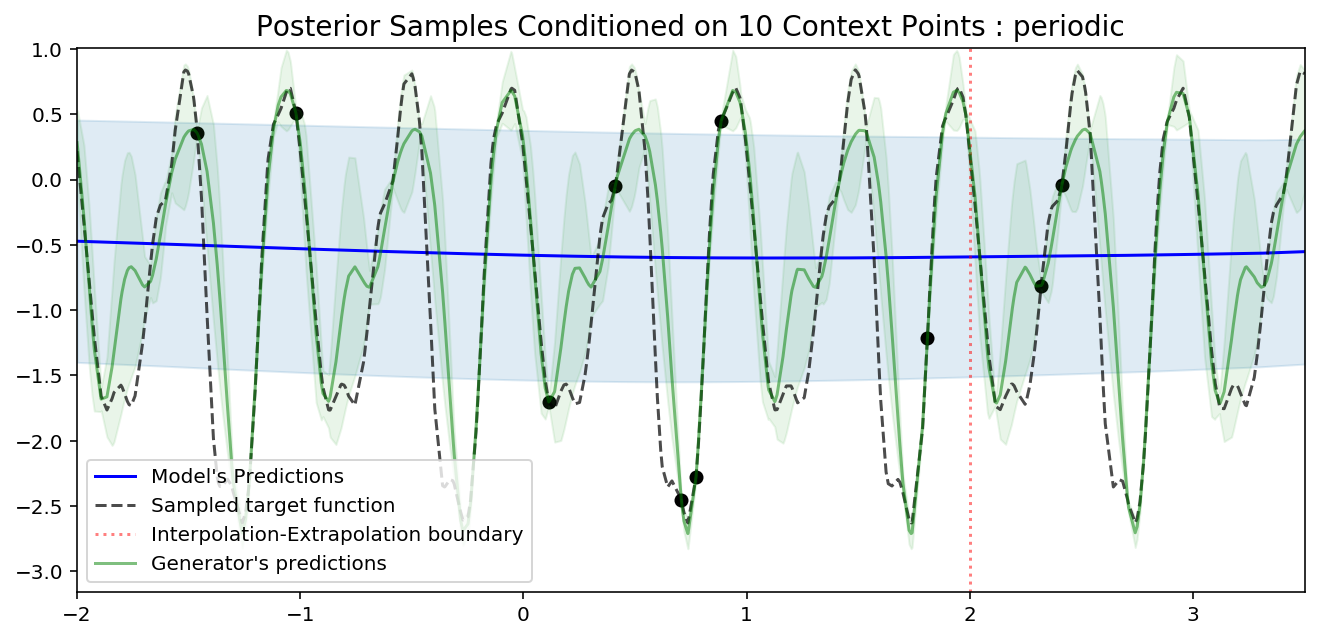

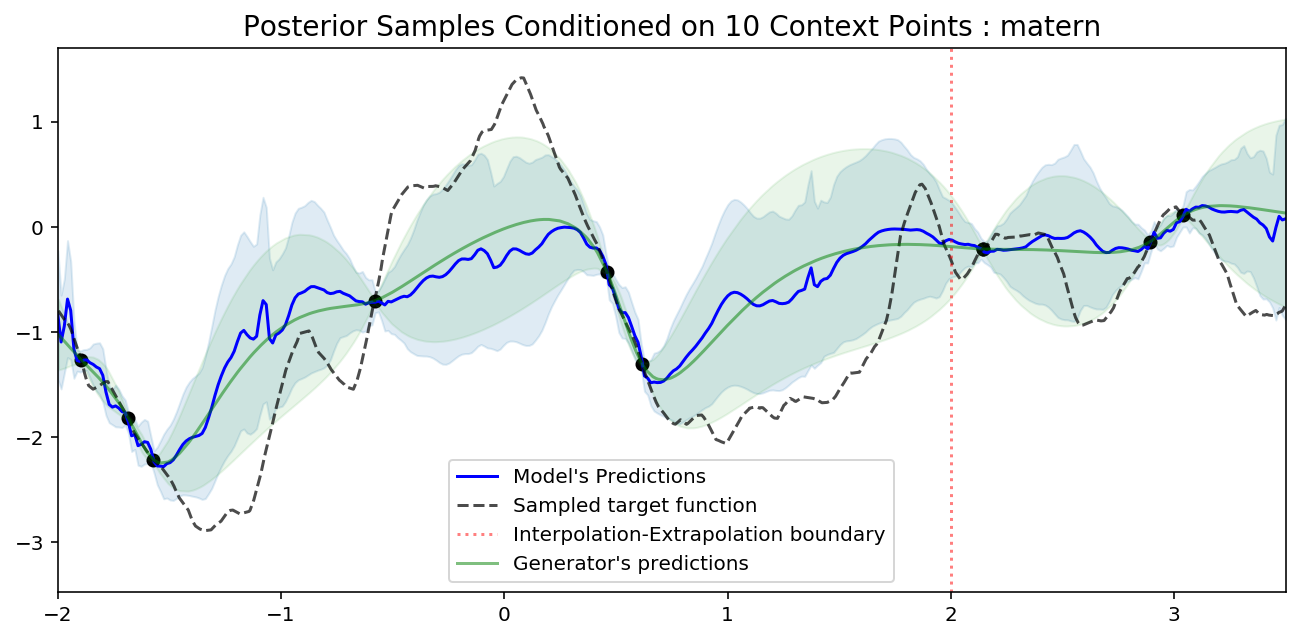

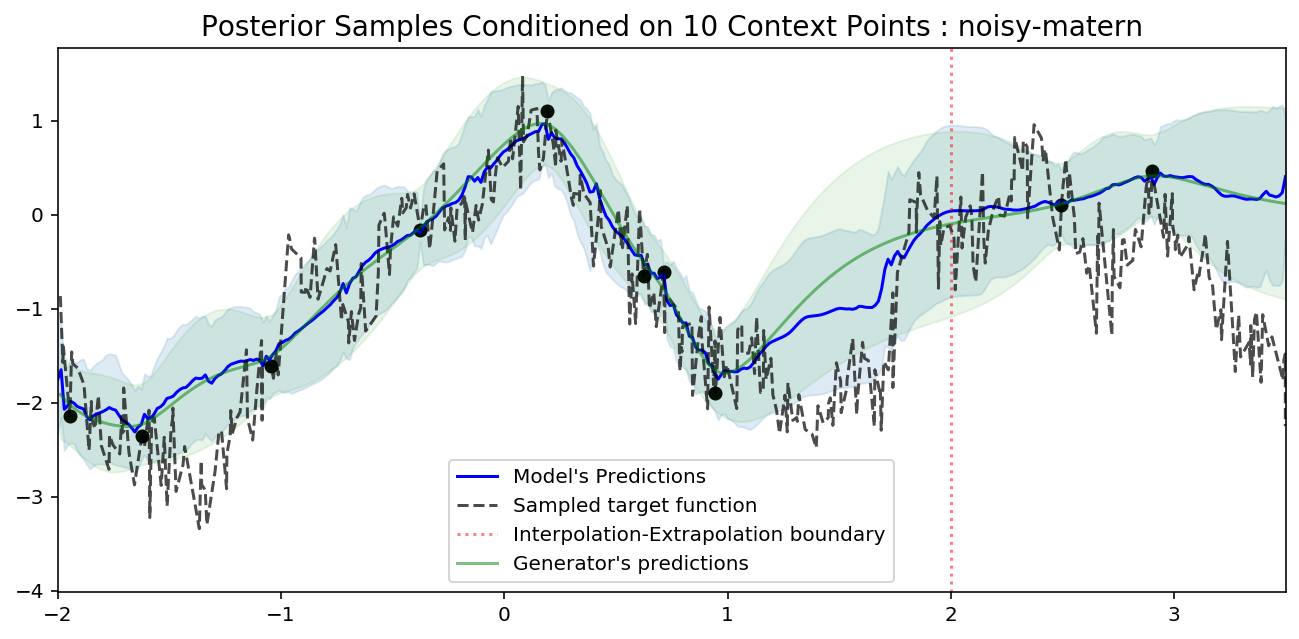

In [24]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.7768186330795288
std: 0.9003379344940186
std: 0.8024296760559082
std: 0.8243255019187927


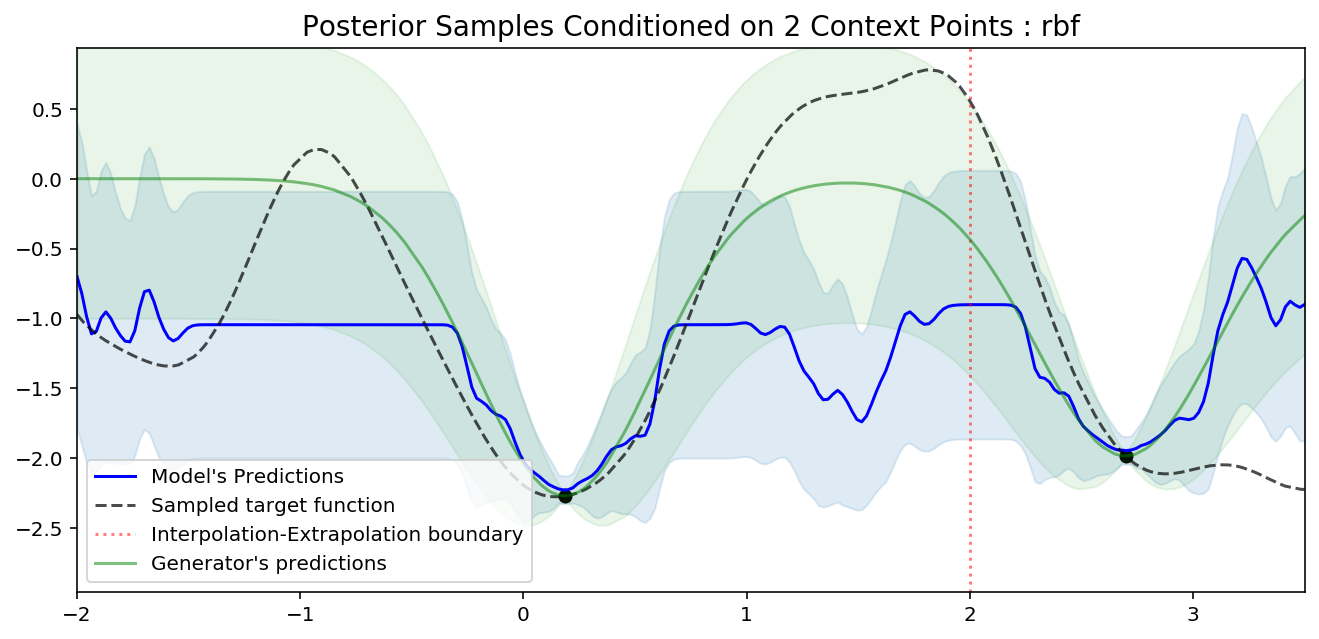

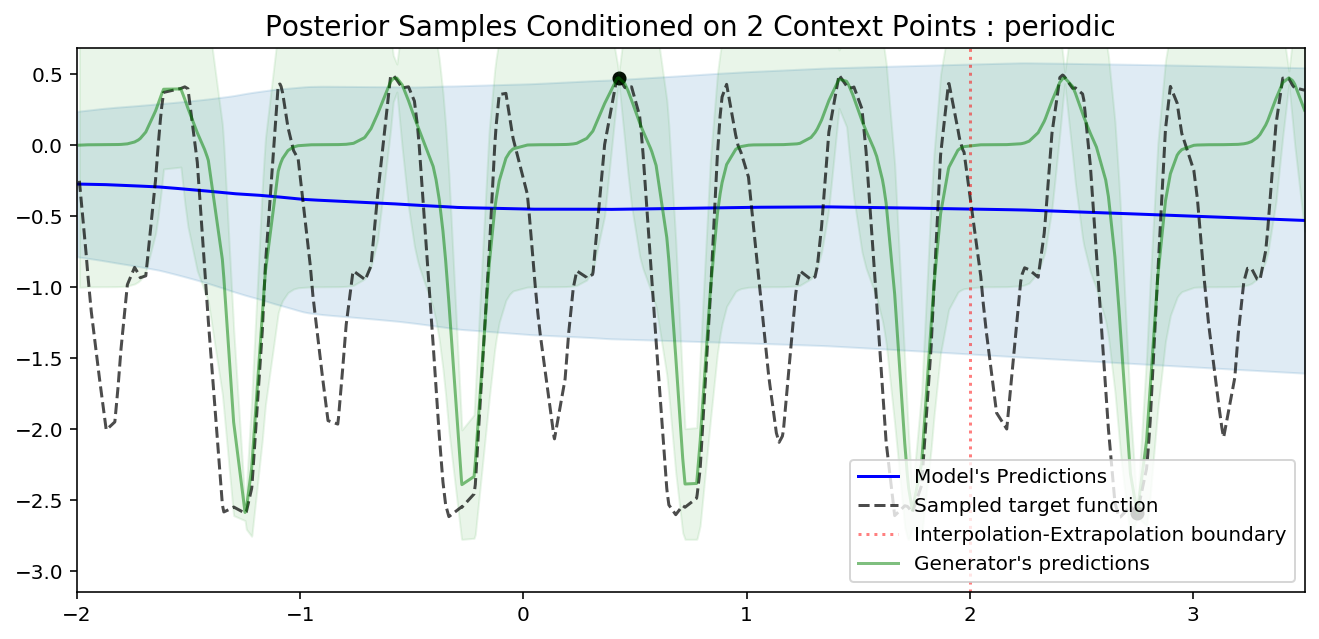

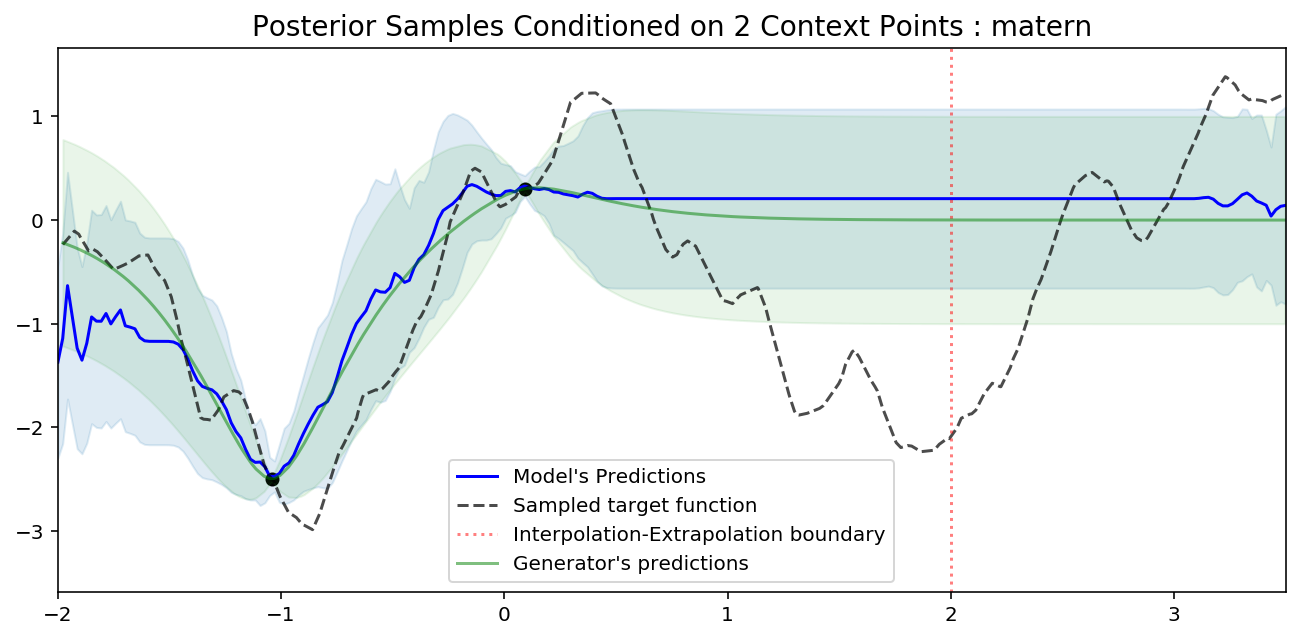

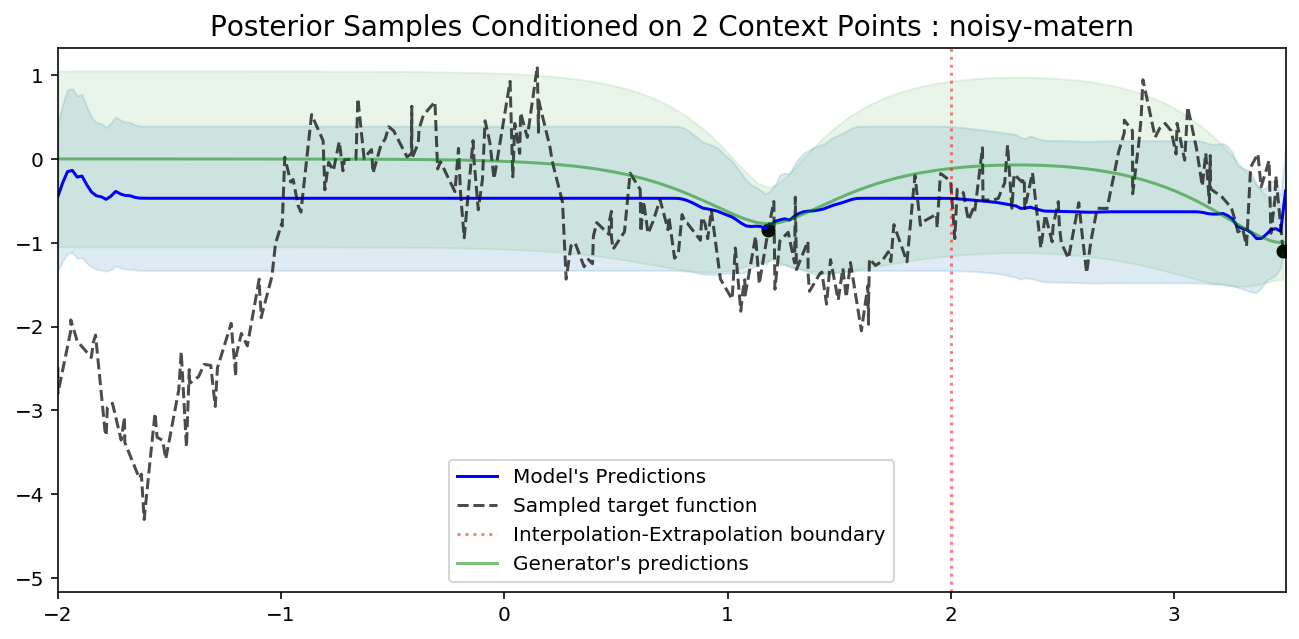

In [25]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.2880578637123108
std: 1.3417606353759766
std: 0.3334498405456543
std: 0.5608278512954712


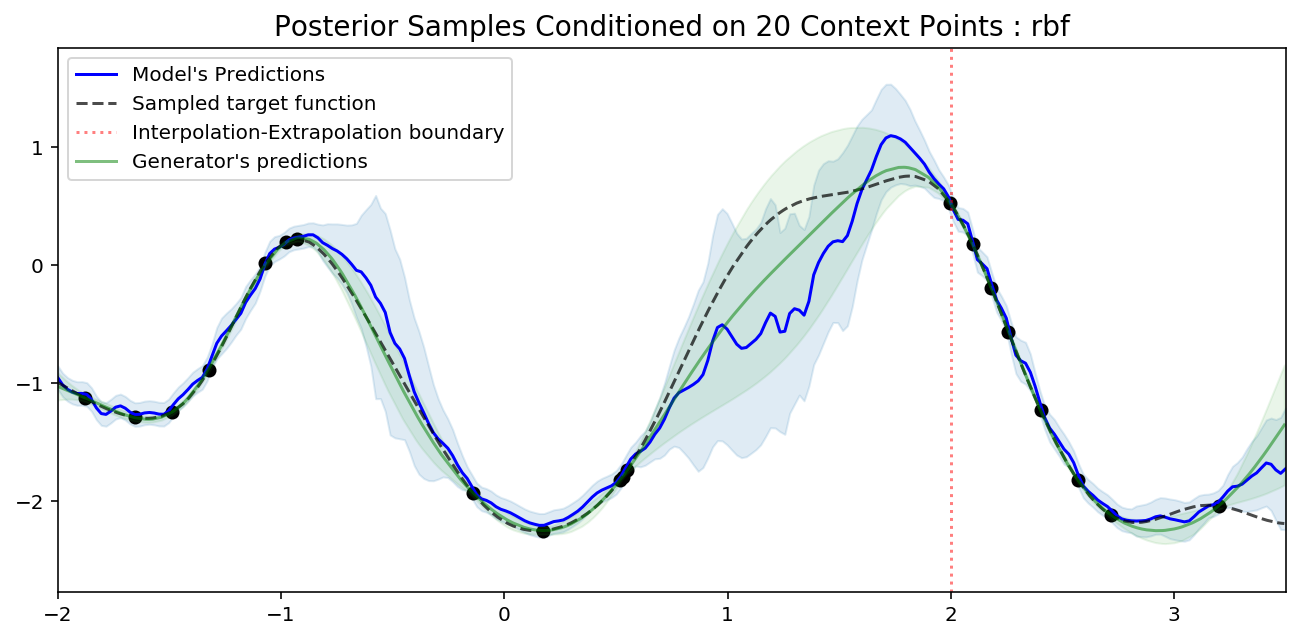

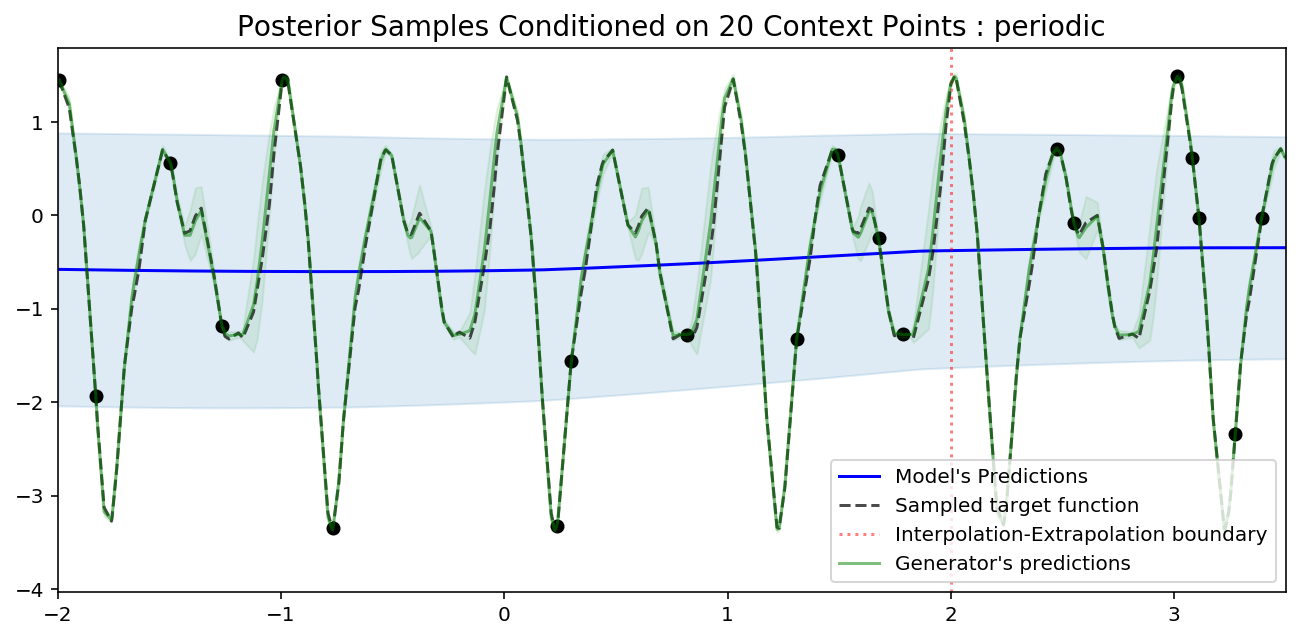

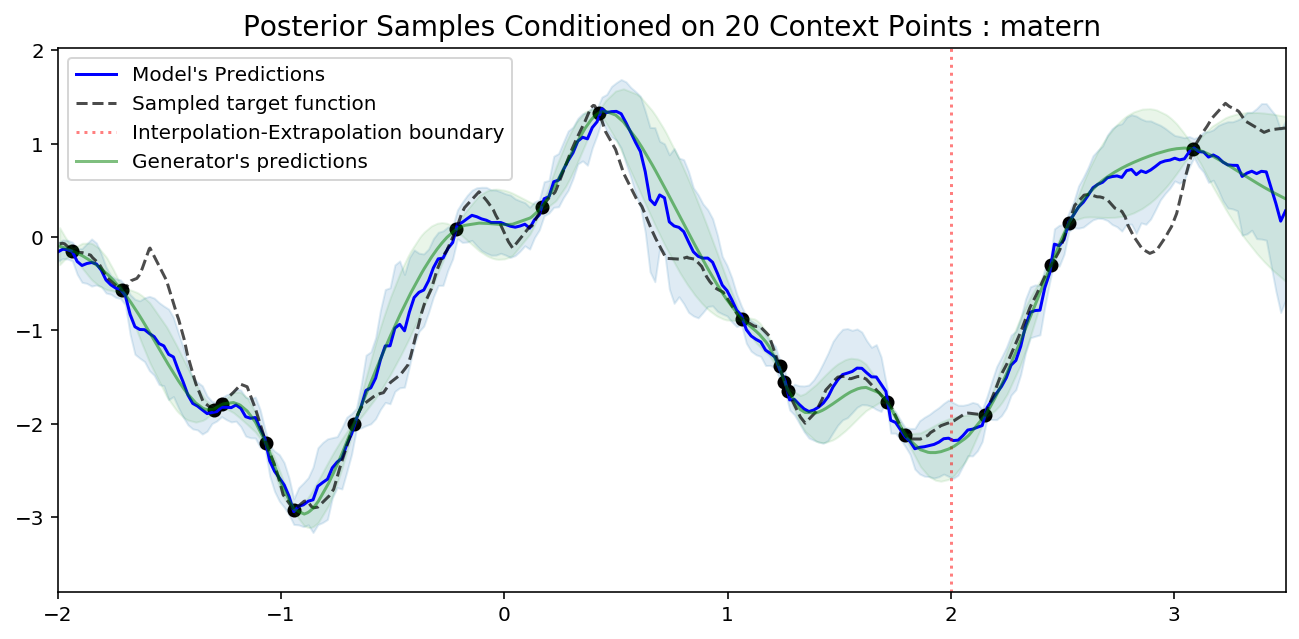

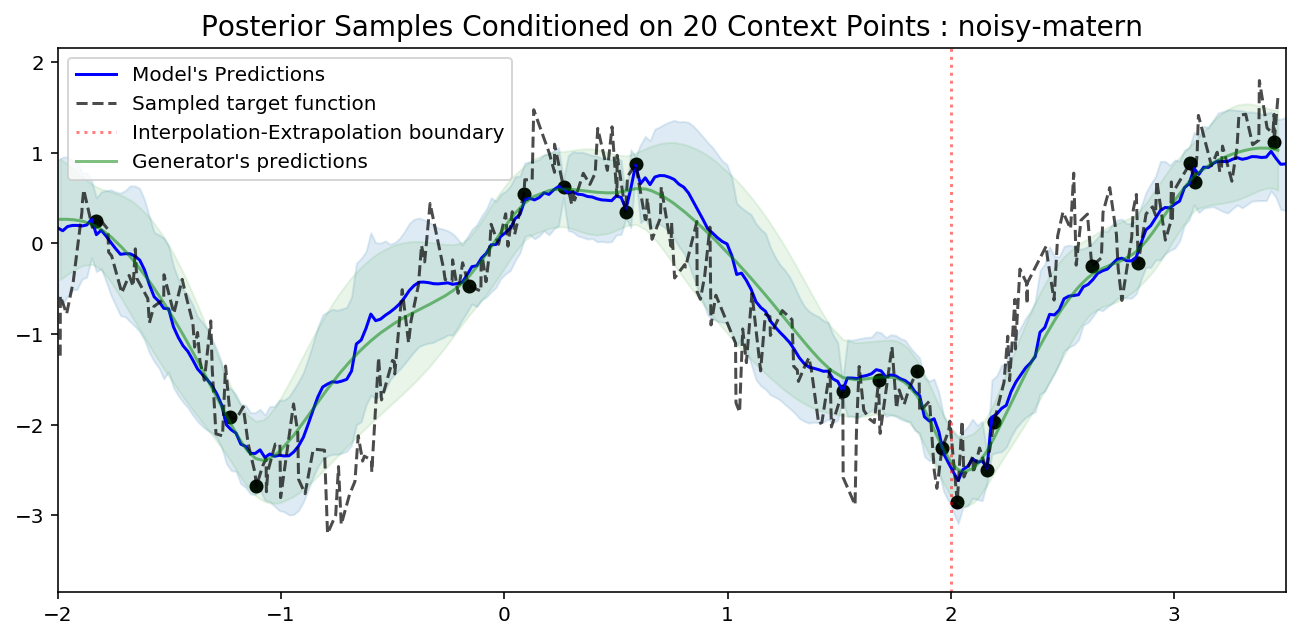

In [26]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.7231670618057251
std: 0.28502413630485535
std: 0.8832384943962097
std: 0.8353458642959595


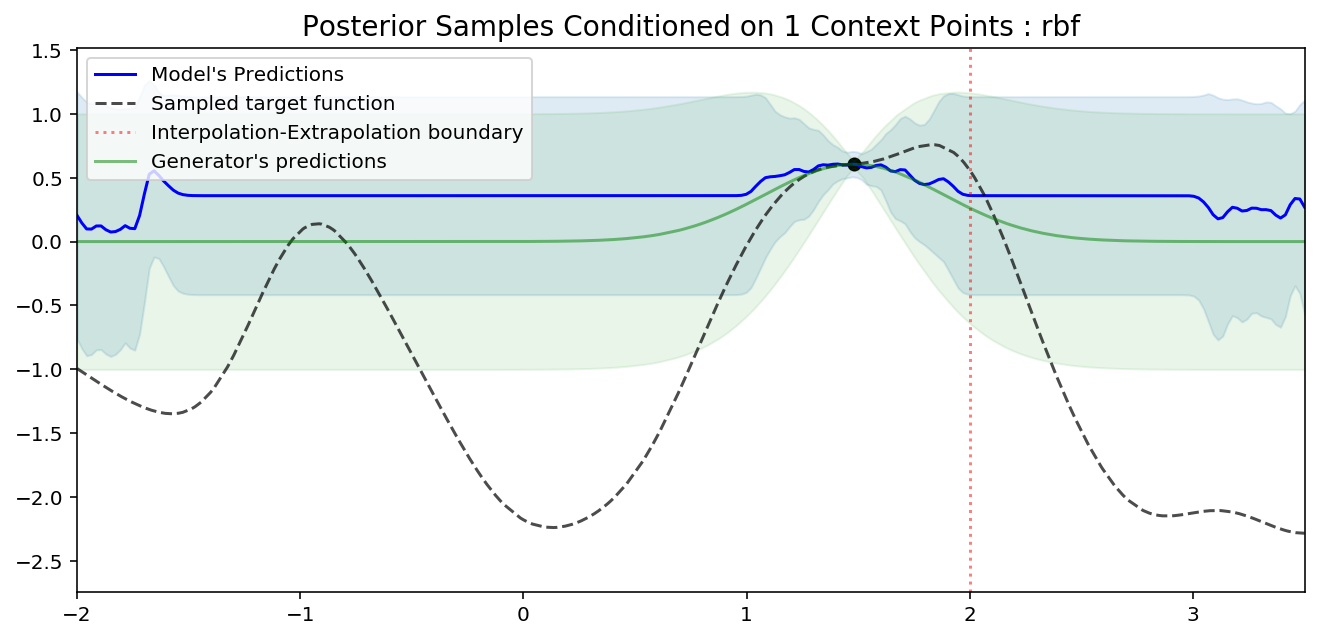

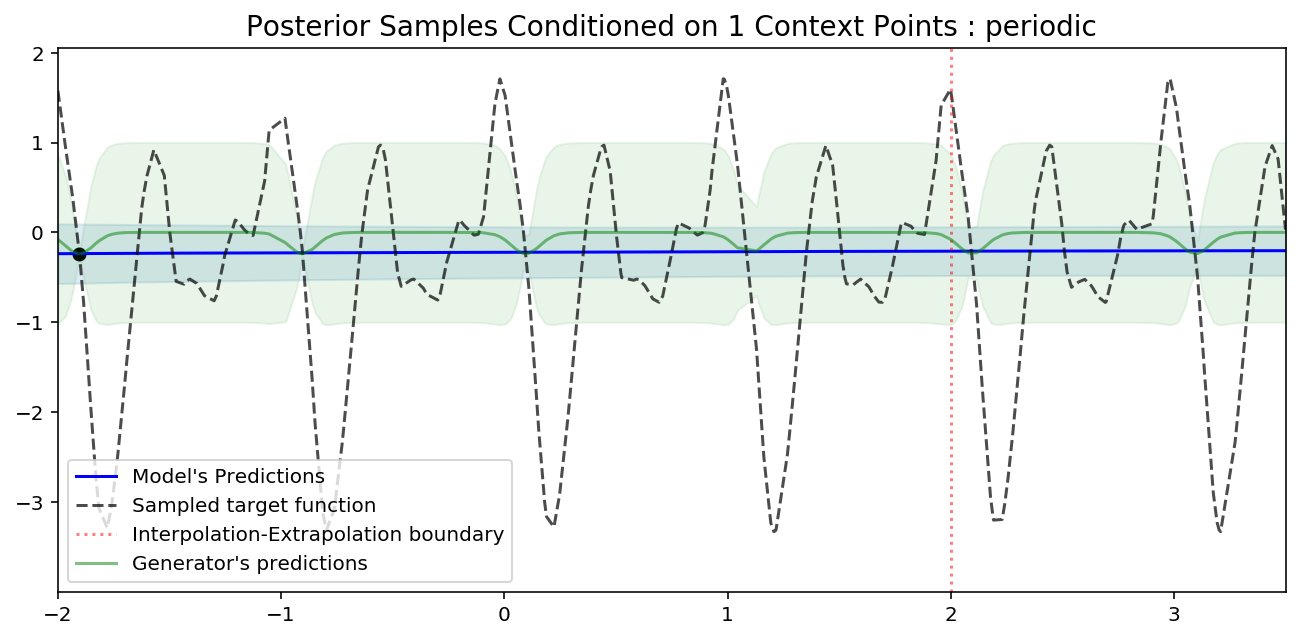

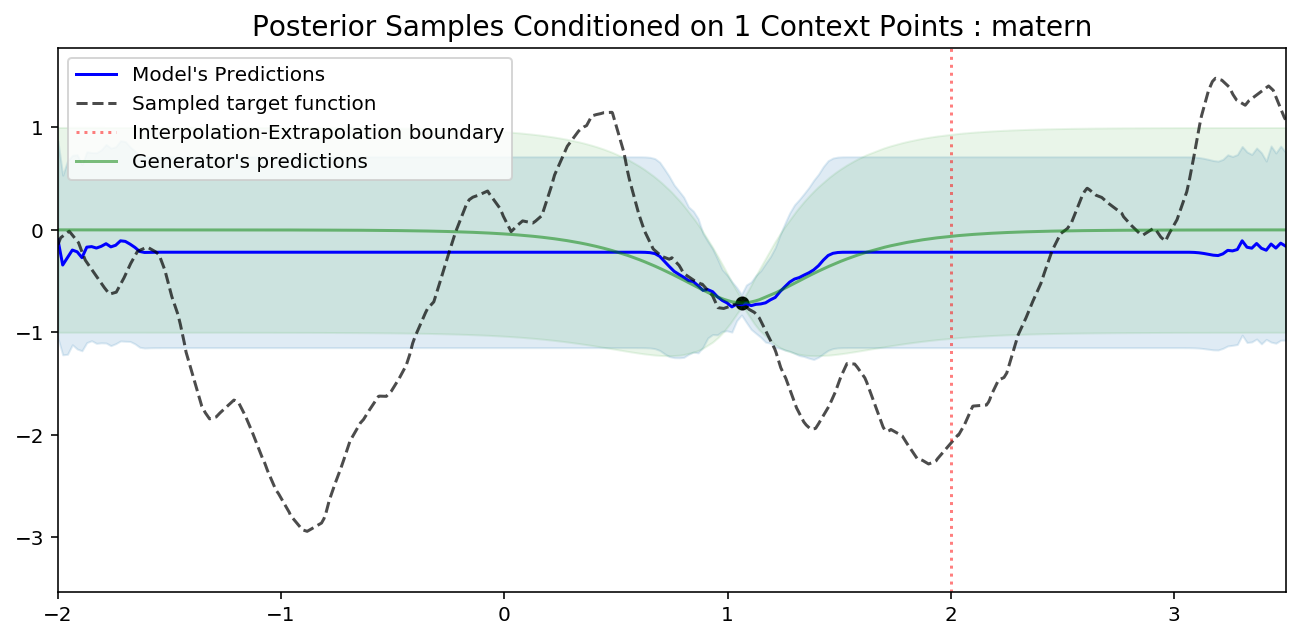

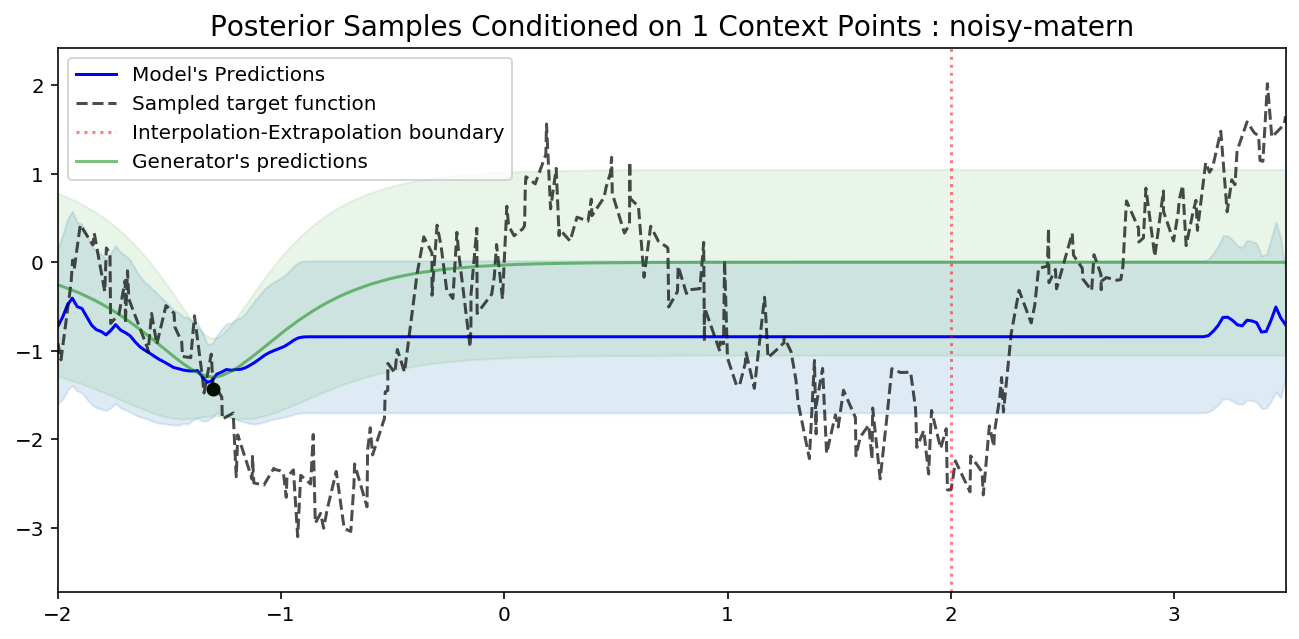

In [27]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- often close to GP with the correct kernel
- the uncertainty decreases close to context points
- no more underfitting : the sampled function all go through or close to the context points
- does all of this with "only" 50k param (and I did not try to go below).
- very good results after $\sim 5$ epochs

**Bad**:
- there seems be some strange "jumps" in regions far from points. This is probably due to the softmax in cross attention, indicating that a head attends to a new point. This makes the model less smooth than GP, but could probably be solved using self attention or a larger model. 
- cannot extrapolate
- still not as smooth as GP
- not good at periodicity

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb